In [1]:
import numpy as np
import pandas as pd
import oandapy as opy
import seaborn as sns ; sns.set()
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


In [2]:
#Get your own Account ID and Token from Oanda Support
import pickle
a = {'accountId':'------', 'token': '----------------------------------------------'}
file_name = "oanda_creds"
fileObject = open(file_name,'wb')
pickle.dump(a,fileObject)
fileObject.close()

In [3]:
oanda_creds = pickle.load(open('oanda_creds','r'))
accountId = oanda_creds['accountId']
token = oanda_creds['token']

In [4]:
oanda = opy.API(environment='practice', access_token = token)

In [5]:
ins = oanda.get_instruments(account_id=accountId)['instruments']

In [6]:
for i in ins:
    print i['instrument'],

AUD_CAD AUD_CHF AUD_HKD AUD_JPY AUD_NZD AUD_SGD AUD_USD CAD_CHF CAD_HKD CAD_JPY CAD_SGD CHF_HKD CHF_JPY CHF_ZAR EUR_AUD EUR_CAD EUR_CHF EUR_CZK EUR_DKK EUR_GBP EUR_HKD EUR_HUF EUR_JPY EUR_NOK EUR_NZD EUR_PLN EUR_SEK EUR_SGD EUR_TRY EUR_USD EUR_ZAR GBP_AUD GBP_CAD GBP_CHF GBP_HKD GBP_JPY GBP_NZD GBP_PLN GBP_SGD GBP_USD GBP_ZAR HKD_JPY NZD_CAD NZD_CHF NZD_HKD NZD_JPY NZD_SGD NZD_USD SGD_CHF SGD_HKD SGD_JPY TRY_JPY USD_CAD USD_CHF USD_CNH USD_CZK USD_DKK USD_HKD USD_HUF USD_JPY USD_MXN USD_NOK USD_PLN USD_SAR USD_SEK USD_SGD USD_THB USD_TRY USD_ZAR ZAR_JPY


In [7]:
#this is just to test that the API works fine
d1 = '2016-10-09'
d2 = '2016-10-11'
data = oanda.get_history(instrument='EUR_HKD', #Our instrument which is meant to be fetched
                        start = d1, end = d2, #start and end dates for fetching
                        granularity='D' #frequency of fetching data, in this case daily
                        )

In [8]:
data

{u'candles': [{u'closeAsk': 8.64376,
   u'closeBid': 8.64125,
   u'complete': True,
   u'highAsk': 8.69741,
   u'highBid': 8.68912,
   u'lowAsk': 8.63755,
   u'lowBid': 8.63519,
   u'openAsk': 8.67624,
   u'openBid': 8.67033,
   u'time': u'2016-10-09T21:00:00.000000Z',
   u'volume': 18192},
  {u'closeAsk': 8.57738,
   u'closeBid': 8.57462,
   u'complete': True,
   u'highAsk': 8.64568,
   u'highBid': 8.64402,
   u'lowAsk': 8.5732,
   u'lowBid': 8.57108,
   u'openAsk': 8.64275,
   u'openBid': 8.6383,
   u'time': u'2016-10-10T21:00:00.000000Z',
   u'volume': 28453}],
 u'granularity': u'D',
 u'instrument': u'EUR_HKD'}

In [9]:
#Backtesting strategy for the data
dates = pd.date_range(start= '2016-02-09', end= '2016-02-12',freq = 'B')
dates

DatetimeIndex(['2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12'], dtype='datetime64[ns]', freq='B')

In [10]:
import os
import datetime
path = "C:\\Users\\yash1\\"
h5 = pd.HDFStore(path + 'backtest_data.h5','w')

In [11]:
%%time
instrument = 'EUR_USD'
df = pd.DataFrame()
print("Retrieving prices for %s instrument"%instrument)
for i in range(0,len(dates)-1):
    d1 = str(dates[i]).replace(' ','T')
    d2 = str(dates[i+1]).replace(' ','T')
    try:
        data = oanda.get_history(instrument = instrument, start = d1, end = d2,
                                alignmentTimezone = 'Europe/Berlin',granularity = 'M1')
        df = df.append(pd.DataFrame(data['candles']))
    except:
        pass
    if i % 25 == 0:
        print '%02d' % i,
        

Retrieving prices for EUR_USD instrument
00Wall time: 17 s



In [12]:
index = pd.DatetimeIndex(df['time'], tz = 'UTC').tz_convert('Europe/Berlin')
df.index = index
del df['time']
h5[instrument] = df

(<matplotlib.axes._subplots.AxesSubplot at 0xc0066a0>,)

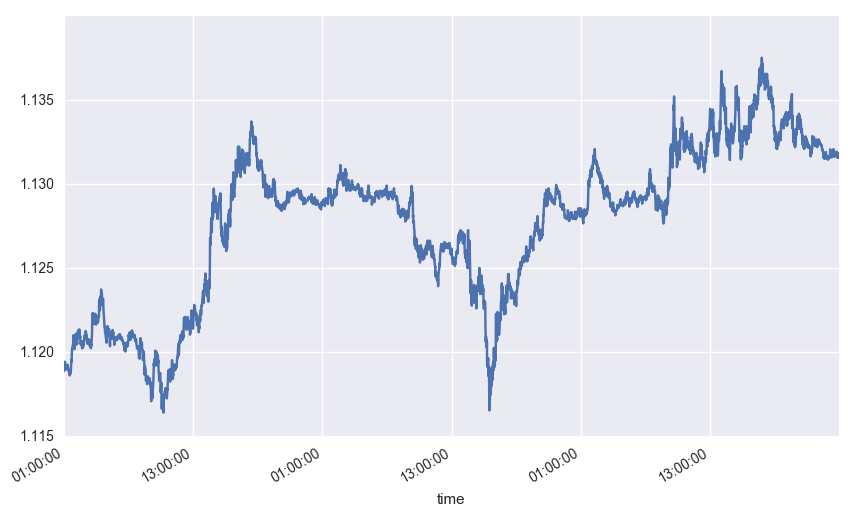

In [13]:
df['closeAsk'].plot(figsize = (10,6)),

(<matplotlib.axes._subplots.AxesSubplot at 0xc10a9b0>,)

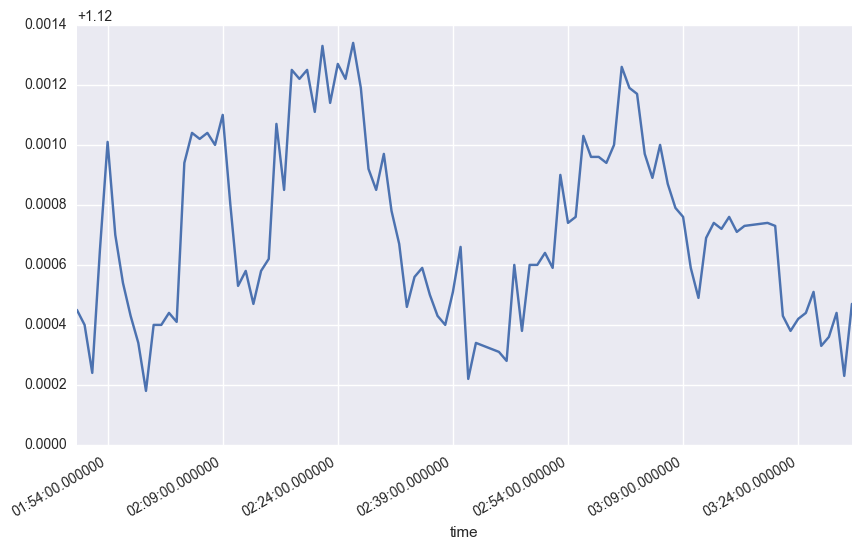

In [14]:
df['closeAsk'].ix[50:150].plot(figsize=(10,6)),

In [15]:
df['returns'] = np.log(df.closeAsk/df.closeAsk.shift(1))

In [16]:
#Basic Trading Strategy

df['t5'] = pd.rolling_mean(df.closeAsk, 5)
#Simple rolling mean for 5 days
df['t15'] = pd.rolling_mean(df.closeAsk, 15)
#Simple rolling mean for 15 days

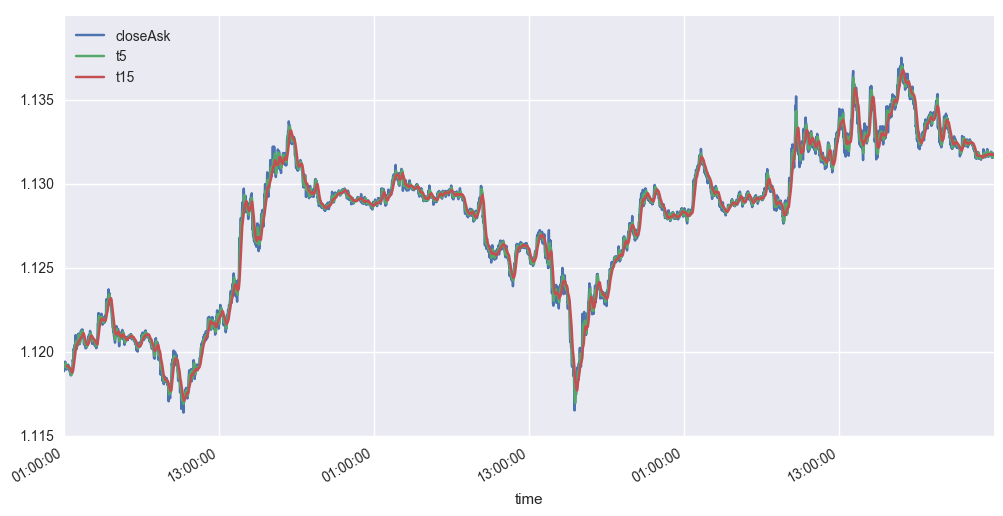

In [17]:
df[['closeAsk','t5','t15']].plot(figsize = (12,6));

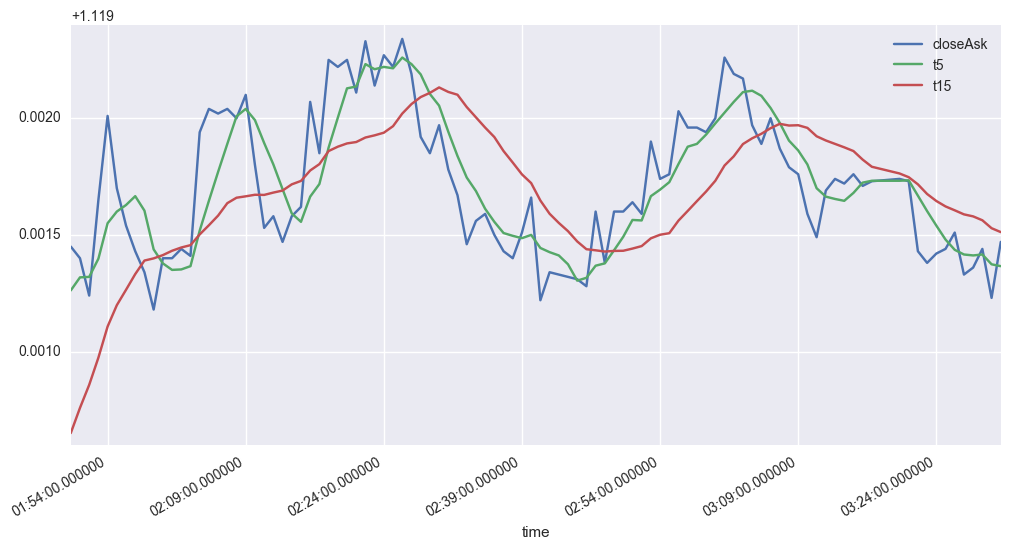

In [18]:
df[['closeAsk','t5','t15']].ix[50:150].plot(figsize = (12,6))

In [19]:
df['position'] = np.where(df.t5 > df.t15, 1, 0)
# If condition holds, go long the market which is represented by +1

In [20]:
df['strategy'] = df.position.shift(1) * df.returns
# previous position combined with current return

In [21]:
df[['returns','strategy']].std()

returns     0.000229
strategy    0.000170
dtype: float64

In [22]:
#Working with streaming data

In [27]:
import json
import time
import requests
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import cufflinks
py.sign_in('yash12392','3c3qzvz0px')

In [28]:
#Getting stream data from streaming APIs
stream_ids = tls.get_credentials_file()['stream_ids']
print stream_ids

#Streaming not working, unable to retrieve stream_ids
#Will work on this later

[]


In [29]:
#Automated Trading

def buy(units):
    oanda.create_order(accountId,
                      instrument = instrument,
                      units = units,
                      side='buy',
                      type='market'
                      )
    print 'Buying %d units' %units
    
def sell(units):
    oanda.create_order(accountId,
                      instrument=instrument,
                      units=units,
                      side = 'sell',
                      type = 'market'
                      )
    print 'Selling %d units'%units

In [30]:
class TrendTrader(opy.Streamer):
    def __init__(self,t1,t2,*args,**kwargs):
        opy.Streamer.__init__(self,*args,**kwargs)
        self.df = pd.DataFrame()
        self.ticks = 0 #Tick data is retrieved
        self.units = 100 #units to trade
        self.t1 = t1 #First Trend
        self.t2 = t2 #Second Trend
        self.invested = False #Not invsted in the begining
    def on_success(self,data):
        self.ticks += 1
        print self.ticks,
        self.df = self.df.append(pd.DataFrame(data['tick'],
                                             index=[data['tick']['time']]))
        index = pd.DatetimeIndex(self.df['time'],tz='UTC').tz_convert('CET')
        
        self.df.index = index
        self.df['t1'] = pd.rolling_mean(self.df['ask'], self.t1)
        self.df['t2'] = pd.rolling_mean(self.df['ask'], self.t2)
        if self.df.t1.ix[-1] > self.df.t2.ix[-1]:
            if self.invested is False:
                buy(self.units)
                self.invested = True
            else:
                if self.invested is True:
                    sell(self.units)
                    self.invested = False
    def on_error(self,data):
        self.disconnect()

In [32]:
usdeur = TrendTrader(t1=5 , t2 = 15, environment = 'practice',access_token = token)
usdeur.start(accountId = accountId, instrument = instrument)
usdeur.disconnect()